#  2022 NYCU Machine Learning HW1 - Linear Regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from numpy.linalg import pinv

# 01 Load Data

In [2]:
dataset_x = pd.read_csv('X.csv')
dataset_t = pd.read_csv('T.csv')

In [3]:
dataset_x.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [4]:
dataset_t.head(5)

,quality
0,5
1,5
2,5
3,6
4,5


# 02 Shuffle

In [5]:
data = pd.concat([dataset_x, dataset_t], axis=1)

In [6]:
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
data_shuff = data.sample(frac=1, random_state=1).reset_index()
data_shuff.drop("index", axis=1, inplace=True)

In [8]:
data_shuff.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.8,0.41,0.64,2.2,0.093,9.0,42.0,0.99860,3.54,0.66,10.5,5
1,8.7,0.63,0.28,2.7,0.096,17.0,69.0,0.99734,3.26,0.63,10.2,6
2,10.4,0.34,0.58,3.7,0.174,6.0,16.0,0.99700,3.19,0.70,11.3,6
3,7.1,0.46,0.20,1.9,0.077,28.0,54.0,0.99560,3.37,0.64,10.4,6
4,7.1,0.39,0.12,2.1,0.065,14.0,24.0,0.99252,3.30,0.53,13.3,6


In [9]:
dataset_x = data_shuff[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']]
dataset_t = data_shuff[['quality']]

In [10]:
dataset_x = np.array(dataset_x)
dataset_t = np.array(dataset_t)

In [11]:
ratio = 0.8
n_target = dataset_t.shape[0]
n_train = int(n_target * ratio)
n_test = n_target - n_train
D = 11

# 2.1 Feature select 

### 2.1(a)

### Method 1

In [12]:
def train_test_split(dataset, split=0.80):    
    num = len(dataset)
    n_train = int(num * split)
    
    dataset_train = dataset[:n_train] 
    dataset_test = dataset[n_train:]
    
    return dataset_train, dataset_test

In [13]:
class LinearRegression():
    def __init__(self, lr=0.0001, epochs=1000, n_features=11):
        self.lr = lr
        self.epochs = epochs
        self.n_features = n_features # Dimension D
        
        # Initialize the weight and bias
        self.w = np.zeros(n_features).reshape(n_features,1)
        self.b = 0
        
        # Create train & val loss list
        self.train_losses = []
        self.val_losses = []
    
    # Forward path
    def forward(self, x):
        return np.dot(x, self.w) + self.b
    
    # Root Mean Square
    def rms(self, y, y_pred):
        error = 0
        for i in range(len(y)):
            error += (y_pred[i] - y[i]) ** 2
            
        error = error / (2*len(y))
        error = error**0.5
        return error[0]

    
    # Train the model
    def train(self, x, y):
        # Gradient Descent
        y_pred = self.forward(x)
        train_loss = self.rms(y, y_pred)
        self.train_losses.append(train_loss)

        # Calculate derivatives
        dw = (1 / x.shape[0]) * (2 * np.dot(x.T, (y_pred - y)))
        db = (1 / x.shape[0]) * (2 * np.sum(y_pred - y))

        # Update the weight
        self.w -= self.lr * dw
        self.b -= self.lr * db
        
        return train_loss

    # Validate
    def val(self, x, y):
        # Forward
        y_pred = self.forward(x)
        val_loss = self.rms(y, y_pred)
        self.val_losses.append(val_loss)
        
        return val_loss
    
    # Training flow
    def train_flow(self, train_x, train_y, val_x, val_y):
        print('----------start training----------')
        for epoch in range(self.epochs):
            print('epoch: {} / {}'.format(epoch, self.epochs))
            
            # train mode
            train_loss = self.train(train_x, train_y)
            
            # val mode
            val_loss = self.val(val_x, val_y)
            
            print('traing loss: {}'.format(train_loss))
            print('validation loss: {}'.format(val_loss))
            print('----------------------------------')

In [14]:
def plotLoss(train_losses, val_losses, epochs, title):
    plt.figure()
    x = np.linspace(1, epochs, epochs)
    plt.plot(train_losses)
    plt.plot(val_losses)
    plt.title(title)
    plt.ylabel('Loss'), plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid("on")
    plt.show()

In [15]:
# Hyperparameter
lr = 1e-6
epochs = 20000

In [16]:
train_set, val_set = train_test_split(data_shuff, split=0.80)

In [17]:
train_x = train_set.iloc[:,:-1].values
train_y = train_set[["quality"]].values
val_x = val_set.iloc[:,:-1].values
val_y = val_set[["quality"]].values

### M=1

In [18]:
model = LinearRegression(lr=lr, epochs=epochs, n_features=11)
model.train_flow(train_x, train_y, val_x, val_y)

----------start training----------
epoch: 0 / 20000
traing loss: 4.025912937515351
validation loss: 4.006259129425295
----------------------------------
epoch: 1 / 20000
traing loss: 4.005919180685323
validation loss: 3.9866255608532466
----------------------------------
epoch: 2 / 20000
traing loss: 3.986115621757049
validation loss: 3.9671846699680513
----------------------------------
epoch: 3 / 20000
traing loss: 3.9665008624145752
validation loss: 3.9479350294464184
----------------------------------
epoch: 4 / 20000
traing loss: 3.9470735114282025
validation loss: 3.9288752186883222
----------------------------------
epoch: 5 / 20000
traing loss: 3.927832184589458
validation loss: 3.9100038237550017
----------------------------------
epoch: 6 / 20000
traing loss: 3.9087755046474135
validation loss: 3.891319437308531
----------------------------------
epoch: 7 / 20000
traing loss: 3.8899021012463915
validation loss: 3.8728206585530343
----------------------------------
epoch: 8 / 

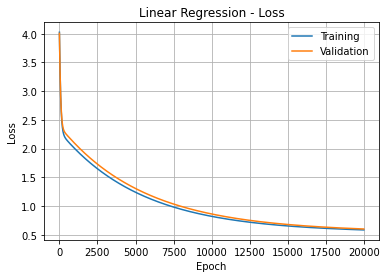

In [19]:
plotLoss(train_losses=model.train_losses, val_losses=model.val_losses, epochs=epochs, title="Linear Regression - Loss")

### Method 2

In [20]:
def weight(phi, t):
    w = np.dot(np.dot(pinv(np.dot(phi, phi.T)), phi),t)
    return w

In [21]:
def rms(n, w, phi, t):
    rms = (np.sum((np.dot(w.T, phi) - t.T)**2) / n)**0.5
    return rms

### M = 1

In [22]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = dataset_x[:n_train,:].T
matrix2_test = dataset_x[n_train:,:].T
phi_matrix_train = np.vstack((matrix1_train, matrix2_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test))

In [23]:
# Weight for M = 1
w_M1 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M1_train = rms(n_train, w_M1, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M1_test = rms(n_test, w_M1, phi_matrix_test, dataset_t[n_train:, :])

### M = 2

In [24]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = dataset_x[:n_train,:].T
matrix2_test = dataset_x[n_train:,:].T
matrix3_train = np.zeros((D**2,n_train))

In [25]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = dataset_x[i,j] * dataset_x[i,k]
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = dataset_x[(n_train+i),j] * dataset_x[(n_train+i),k]
            m = m + 1
            
phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [26]:
# Weight for M = 2
w_M2 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M2_train = rms(n_train, w_M2, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M2_test = rms(n_test, w_M2, phi_matrix_test, dataset_t[n_train:, :])

In [27]:
print("----------Polynomial----------\n")
print("M=1")
print("RMS train: ", RMS_M1_train)
print("RMS val  : ", RMS_M1_test,"\n")

print("M=2")
print("RMS train: ", RMS_M2_train)
print("RMS val  : ", RMS_M2_test)

----------Polynomial----------

M=1
RMS train:  0.64310530043101
RMS val  :  0.6598255614779065 

M=2
RMS train:  0.6048685472553934
RMS val  :  0.6474326189304004


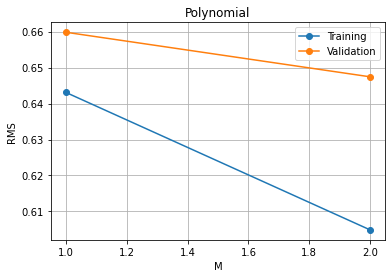

In [28]:
plt.title('Polynomial')
plt.xlabel('M')
plt.ylabel('RMS')
plt.plot([1,2],[RMS_M1_train,RMS_M2_train],marker = "o",label='Training')
plt.plot([1,2],[RMS_M1_test,RMS_M2_test],marker = "o",label='Validation')
plt.legend(loc=0)
plt.grid('on')
plt.show()

### 2.1(b) Select the most contributive feature

In [29]:
wo_fixed_acidity = np.delete(dataset_x, 0, 1)
wo_volatile_acidity = np.delete(dataset_x, 1, 1)
wo_citric_acid = np.delete(dataset_x, 2, 1)
wo_residual_sugar = np.delete(dataset_x, 3, 1)
wo_chlorides = np.delete(dataset_x, 4, 1)
wo_free_sulfur_dioxide = np.delete(dataset_x, 5, 1)
wo_total_sulfur_dioxide = np.delete(dataset_x, 6, 1)
wo_density = np.delete(dataset_x, 7, 1)
wo_pH = np.delete(dataset_x, 8, 1)
wo_sulphates = np.delete(dataset_x, 9, 1)
wo_alcohol = np.delete(dataset_x, 10, 1)

# Create lists
data_list = [wo_fixed_acidity,
             wo_volatile_acidity,
             wo_citric_acid,
             wo_residual_sugar,
             wo_chlorides,
             wo_free_sulfur_dioxide,
             wo_total_sulfur_dioxide,
             wo_density,
             wo_pH,
             wo_sulphates,
             wo_alcohol]

name_list = ['fixed acidity',
             'volatile acidity',
             'citric acid',
             'residual sugar',
             'chlorides',
             'free sulfur dioxide',
             'total sulfur dioxide',
             'density',
             'pH',
             'sulphates',
             'alcohol']

RMS_M1_train_list = list()
RMS_M1_test_list = list()

matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])


In [30]:
for i in range(0,D):
    matrix2_train = data_list[i][:n_train,:].T
    matrix2_test = data_list[i][n_train:,:].T
    phi_matrix_train = np.vstack((matrix1_train, matrix2_train))
    phi_matrix_test = np.vstack((matrix1_test, matrix2_test))
    
    # Weight for M = 1
    w_M1 = weight(phi_matrix_train, dataset_t[:n_train, :])
    RMS_M1_train = rms(n_train, w_M1, phi_matrix_train, dataset_t[:n_train, :])
    RMS_M1_test = rms(n_test, w_M1, phi_matrix_test, dataset_t[n_train:, :])
    
    # Add values to lists
    RMS_M1_train_list.append(RMS_M1_train)
    RMS_M1_test_list.append(RMS_M1_test)
    
    print("Without", name_list[i])
    print("RMS train (M=1): ", RMS_M1_train_list[i])
    print("RMS val   (M=1): ", RMS_M1_test_list[i])
    print("----------------------------------------")

Without fixed acidity
RMS train (M=1):  0.6432004883993807
RMS val   (M=1):  0.660258294104995
----------------------------------------
Without volatile acidity
RMS train (M=1):  0.6566133003817675
RMS val   (M=1):  0.6853076225219312
----------------------------------------
Without citric acid
RMS train (M=1):  0.6433718794368206
RMS val   (M=1):  0.6603597680872725
----------------------------------------
Without residual sugar
RMS train (M=1):  0.6437111390442432
RMS val   (M=1):  0.6579648122200035
----------------------------------------
Without chlorides
RMS train (M=1):  0.6472555297543378
RMS val   (M=1):  0.6638912250554543
----------------------------------------
Without free sulfur dioxide
RMS train (M=1):  0.6437223143621548
RMS val   (M=1):  0.6615138334389923
----------------------------------------
Without total sulfur dioxide
RMS train (M=1):  0.6469844790850213
RMS val   (M=1):  0.6646846077037672
----------------------------------------
Without density
RMS train (M=1)

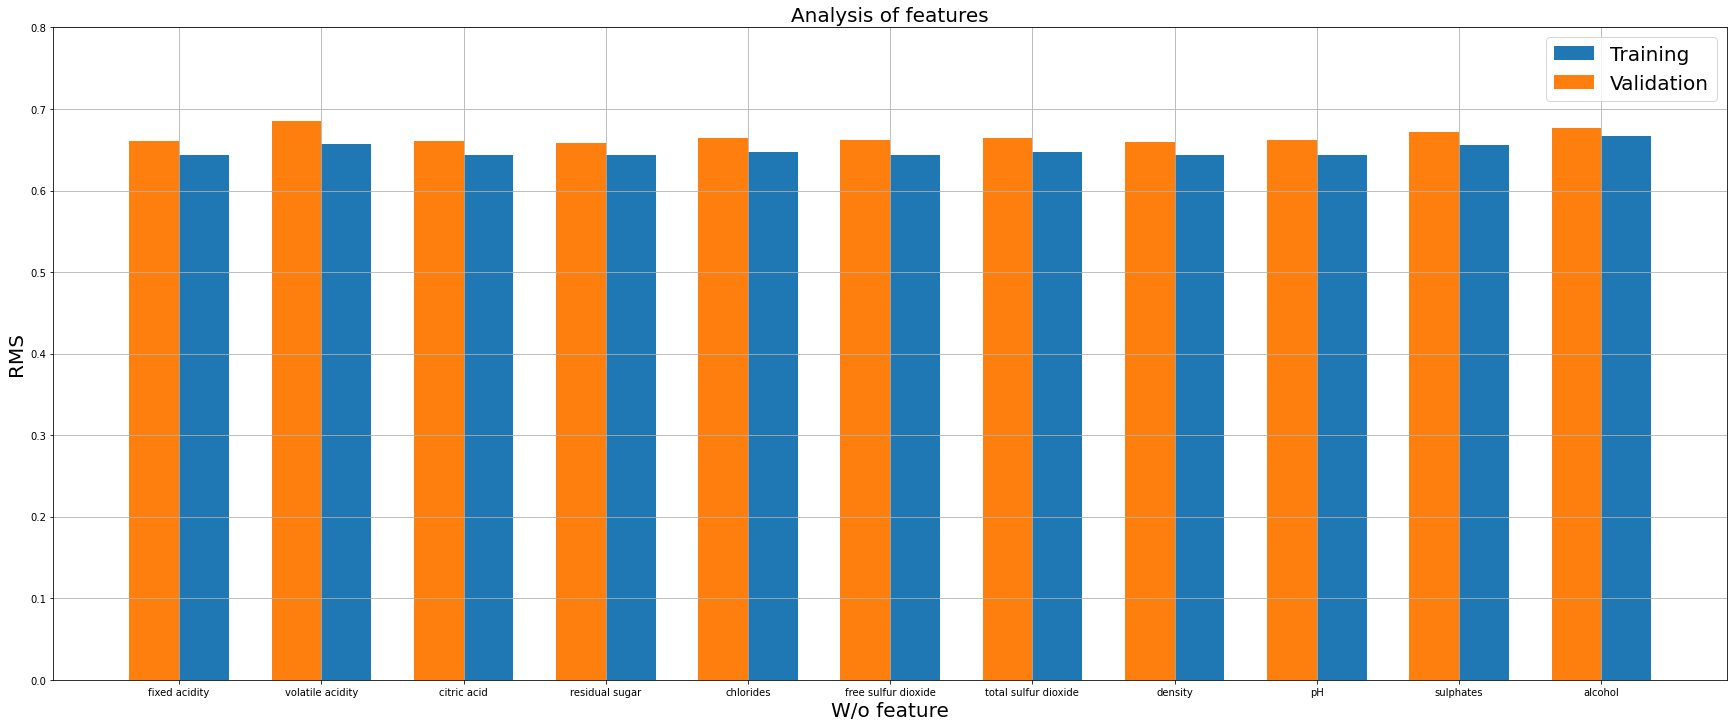

In [31]:
plt.figure(figsize=(30,12))
plt.bar(name_list, RMS_M1_train_list, label = 'Training', align = "edge", width = 0.35)
plt.bar(name_list, RMS_M1_test_list, label = 'Validation', align = "edge", width = -0.35)
plt.title("Analysis of features", fontsize = 20)
plt.xlabel("W/o feature", fontsize = 20)
plt.ylabel("RMS", fontsize = 20)
plt.ylim(0,0.8)
plt.legend(loc=0, fontsize = 20)
plt.grid('on')
plt.show()

<Figure size 720x720 with 0 Axes>

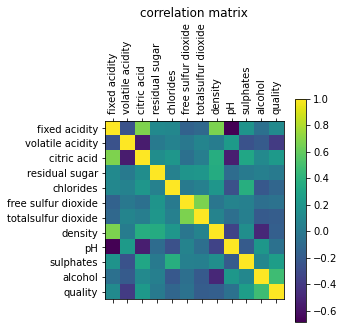

In [32]:
corr_matrix = data.corr()
matrix = corr_matrix.to_numpy()

groups = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'totalsulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

plt.figure(figsize=(10,10))

plt.matshow(matrix, interpolation='nearest')
plt.colorbar()

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups, rotation='vertical')
y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

plt.title("correlation matrix")
plt.show()

## 2.2 Maximum likelihood approach

### 2.2 (b) 
### Gaussian basis function

In [33]:
# Calculate mean & variance
mu = np.zeros((D,1))
variance = np.zeros((D,1))

for i in range(0,D):
    mu[i] = np.sum(dataset_x[:n_train,i]) / n_train
    
for i in range(0,D):
    variance[i] = np.sum((dataset_x[:n_train,i] - mu[i])**2) / n_train

# Expand arrays
mu_train = np.tile(mu,(1,n_train))
mu_test = np.tile(mu,(1,n_test))
variance_train = np.tile(variance,(1,n_train))
variance_test = np.tile(variance,(1,n_test))

In [34]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = np.exp(-((dataset_x[:n_train,:].T - mu_train)**2) / (2*variance_train))
matrix2_test = np.exp(-((dataset_x[n_train:,:].T - mu_test)**2) / (2*variance_test))
phi_matrix_train = np.vstack((matrix1_train, matrix2_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test))

In [35]:
# Weight for M = 1
w_M1 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M1_train = rms(n_train, w_M1, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M1_test = rms(n_test, w_M1, phi_matrix_test, dataset_t[n_train:, :])

In [36]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = np.exp(-((dataset_x[:n_train,:].T - mu_train)**2) / (2*variance_train))
matrix2_test = np.exp(-((dataset_x[n_train:,:].T - mu_test)**2) / (2*variance_test))
matrix3_train = np.zeros((D**2,n_train))

In [37]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = np.exp(-(((dataset_x[i,j] - mu[j])**2 / (2*variance[j])) + ((dataset_x[i,k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = np.exp(-(((dataset_x[(n_train+i),j] - mu[j])**2 / (2*variance[j])) + ((dataset_x[(n_train+i),k] - mu[k])**2 / (2*variance[k]))))
            m = m + 1
            
phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [38]:
# Weight for M = 2
w_M2 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M2_train = rms(n_train, w_M2, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M2_test = rms(n_test, w_M2, phi_matrix_test, dataset_t[n_train:, :])

In [39]:
print("----------Gaussian----------\n")
print("M=1")
print("RMS train: ", RMS_M1_train)
print("RMS val:  ", RMS_M1_test, "\n")

print("M=2")
print("RMS train: ", RMS_M2_train)
print("RMS val:  ", RMS_M2_test)

----------Gaussian----------

M=1
RMS train:  0.7592669615485866
RMS val:   0.8008020247068542 

M=2
RMS train:  0.6923484347609844
RMS val:   0.7566264445030028


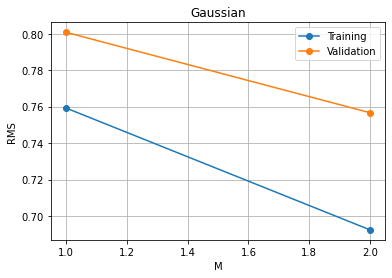

In [40]:
plt.title('Gaussian')
plt.xlabel('M')
plt.ylabel('RMS')
plt.plot([1,2],[RMS_M1_train,RMS_M2_train],marker = "o",label='Training')
plt.plot([1,2],[RMS_M1_test,RMS_M2_test],marker = "o",label='Validation')
plt.legend(loc=0,)
plt.grid('on')
plt.show()

### Sigmoidal basis function

In [41]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = 1 / (1 + np.exp(-(dataset_x[:n_train,:].T - mu_train)))
matrix2_test = 1 / (1 + np.exp(-(dataset_x[n_train:,:].T - mu_test)))
phi_matrix_train = np.vstack((matrix1_train, matrix2_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test))

In [42]:
# Weight for M = 1
w_M1 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M1_train = rms(n_train, w_M1, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M1_test = rms(n_test, w_M1, phi_matrix_test, dataset_t[n_train:, :])

In [43]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = 1 / (1 + np.exp(-(dataset_x[:n_train,:].T - mu_train)))
matrix2_test = 1 / (1 + np.exp(-(dataset_x[n_train:,:].T - mu_test)))
matrix3_train = np.zeros((D**2,n_train))

In [44]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = (1 / (1 + np.exp(-(dataset_x[i,j] - mu[j])))) * (1 / (1 + np.exp(-(dataset_x[i,k] - mu[k]))))
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = (1 / (1 + np.exp(-(dataset_x[(n_train+i),j] - mu[j])))) * (1 / (1 + np.exp(-(dataset_x[(n_train+i),k] - mu[k]))))
            m = m + 1

phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [45]:
# Weight for M = 2
w_M2 = weight(phi_matrix_train, dataset_t[:n_train, :])

# RMS (training)
RMS_M2_train = rms(n_train, w_M2, phi_matrix_train, dataset_t[:n_train, :])

# RMS (testing)
RMS_M2_test = rms(n_test, w_M2, phi_matrix_test, dataset_t[n_train:, :])

In [46]:
print("----------Sigmoidal----------\n")
print("M=1")
print("RMS train: ", RMS_M1_train)
print("RMS val:   ", RMS_M1_test,"\n")

print("M=2")
print("RMS train: ", RMS_M2_train)
print("RMS val:   ", RMS_M2_test)

----------Sigmoidal----------

M=1
RMS train:  0.6412945700979797
RMS val:    0.6648415660339035 

M=2
RMS train:  0.6042039194969999
RMS val:    0.6569981607249855


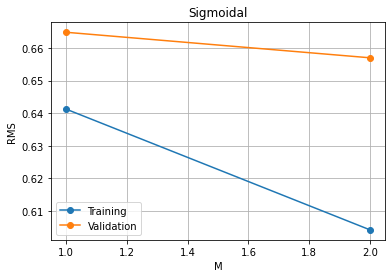

In [47]:
plt.title('Sigmoidal')
plt.xlabel('M')
plt.ylabel('RMS')
plt.plot([1,2],[RMS_M1_train,RMS_M2_train],marker = "o",label='Training')
plt.plot([1,2],[RMS_M1_test,RMS_M2_test],marker = "o",label='Validation')
plt.legend(loc=0)
plt.grid('on')
plt.show()

### 2.2 (c) N-fold cross-validation with ML

In [48]:
N = 10
ratio = 1 / N
n_test_NFold = int(n_target * ratio)
n_train_NFold = n_target - n_test_NFold
RMS_M1_train = np.zeros((1,N))
RMS_M1_test = np.zeros((1,N))
RMS_M2_train = np.zeros((1,N))
RMS_M2_test = np.zeros((1,N))

In [49]:
for r in range(N):
    dataset_x_test = dataset_x[range((n_test_NFold*r),(n_test_NFold*(r+1))),:]
    dataset_t_test = dataset_t[range((n_test_NFold*r),(n_test_NFold*(r+1))),:]
    dataset_x_train = np.delete(dataset_x, [range((n_test_NFold*r),(n_test_NFold*(r+1)))], axis=0)
    dataset_t_train = np.delete(dataset_t, [range((n_test_NFold*r),(n_test_NFold*(r+1)))], axis=0)
    # Create phi_matrix for M = 1 & M = 2
    matrix1_train = np.ones([1, n_train_NFold])
    matrix1_test = np.ones([1, n_test_NFold])
    matrix2_train = dataset_x_train.T
    matrix2_test = dataset_x_test.T
    matrix3_train = np.zeros((D**2,n_train_NFold))
    
    for i in range(0,n_train_NFold):
        m = 0
        for j in range(0,D):
            for k in range(0,D):
                matrix3_train[m,i] = dataset_x_train[i,j] * dataset_x_train[i,k]
                m = m + 1
                
    matrix3_test = np.zeros((D**2,n_test_NFold))
    
    for i in range(0,n_test_NFold):
        m = 0
        for j in range(0,D):
            for k in range(0,D):
                matrix3_test[m,i] = dataset_x_test[i,j] * dataset_x_test[i,k]
                m = m + 1
                
    phi_matrix_M1_train = np.vstack((matrix1_train, matrix2_train))
    phi_matrix_M1_test = np.vstack((matrix1_test, matrix2_test))
    phi_matrix_M2_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
    phi_matrix_M2_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))
    
    # Weights for M = 1 & M = 2
    w_M1 = weight(phi_matrix_M1_train, dataset_t_train)
    w_M2 = weight(phi_matrix_M2_train, dataset_t_train)

    # RMSs
    RMS_M1_train[0,r] = (np.sum((np.dot(w_M1.T, phi_matrix_M1_train) - dataset_t_train.T)**2) / n_train_NFold)**0.5
    RMS_M1_test[0,r] = (np.sum((np.dot(w_M1.T, phi_matrix_M1_test) - dataset_t_test.T)**2) / n_test_NFold)**0.5
    RMS_M2_train[0,r] = (np.sum((np.dot(w_M2.T, phi_matrix_M2_train) - dataset_t_train.T)**2) / n_train_NFold)**0.5
    RMS_M2_test[0,r] = (np.sum((np.dot(w_M2.T, phi_matrix_M2_test) - dataset_t_test.T)**2) / n_test_NFold)**0.5

In [50]:
a = [RMS_M1_train, RMS_M1_test, RMS_M2_train, RMS_M2_test]
name = ['RMS train (M=1)', 'RMS val (M=1)', 'RMS train (M=2)', 'RMS val (M=2)']
mean_list = list()
print("N-fold cross-validation with ML\n")

for i in range(4):
    mu = np.mean(a[i])
    mean_list.append(mu)
    variance = np.var(a[i])
    print(name[i], ":")
    print("mean:     ", mu)
    print("variance: ", variance, "\n")

N-fold cross-validation with ML

RMS train (M=1) :
mean:      0.6453792623844965
variance:  2.6877314763708544e-05 

RMS val (M=1) :
mean:      0.6480426520189771
variance:  0.002541810107620268 

RMS train (M=2) :
mean:      0.6070894502478673
variance:  2.3612270898815526e-05 

RMS val (M=2) :
mean:      0.6482231719460065
variance:  0.0021716330378396065 



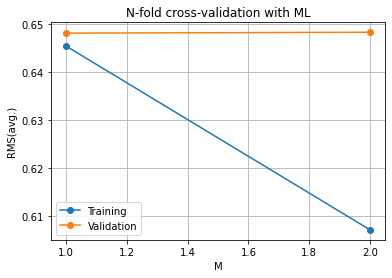

In [51]:
plt.title('N-fold cross-validation with ML')
plt.xlabel('M')
plt.ylabel('RMS(avg.)')
plt.plot([1,2],[mean_list[0],mean_list[2]],marker = "o",label='Training')
plt.plot([1,2],[mean_list[1],mean_list[3]],marker = "o",label='Validation')
plt.legend(loc=0)
plt.grid('on')
plt.show()

## 2.3 Maximum a posterior approach

### 2.3(b)

In [102]:
Lambda = 0.5

matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = dataset_x[:n_train,:].T
matrix2_test = dataset_x[n_train:,:].T
phi_matrix_train = np.vstack((matrix1_train, matrix2_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test))

In [103]:
# Weight for M = 1 with lambda
w_M1 = np.dot(np.dot(pinv(np.dot(phi_matrix_train, phi_matrix_train.T) + Lambda*np.eye(D+1)), phi_matrix_train), dataset_t[:n_train, :])

# RMS for training data
RMS_M1_train = math.sqrt((np.sum((np.dot(w_M1.T, phi_matrix_train) - dataset_t[:n_train, :].T)**2) + Lambda*np.dot(w_M1.T,w_M1)) / n_train)

# RMS for testing data
RMS_M1_test = math.sqrt((np.sum((np.dot(w_M1.T, phi_matrix_test) - dataset_t[n_train:, :].T)**2) + Lambda*np.dot(w_M1.T,w_M1)) / n_test)

In [104]:
matrix1_train = np.ones([1, n_train])
matrix1_test = np.ones([1, n_test])
matrix2_train = dataset_x[:n_train,:].T
matrix2_test = dataset_x[n_train:,:].T
matrix3_train = np.zeros((D**2,n_train))

In [105]:
for i in range(0,n_train):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_train[m,i] = dataset_x[i,j] * dataset_x[i,k]
            m = m + 1
            
matrix3_test = np.zeros((D**2,n_test))

for i in range(0,n_test):
    m = 0
    for j in range(0,D):
        for k in range(0,D):
            matrix3_test[m,i] = dataset_x[(n_train+i),j] * dataset_x[(n_train+i),k]
            m = m + 1
            
phi_matrix_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
phi_matrix_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))

In [106]:
# Weight for M = 2 with lambda
w_M2 = np.dot(np.dot(pinv(np.dot(phi_matrix_train, phi_matrix_train.T) + Lambda*np.eye(1+D+D**2)), phi_matrix_train), dataset_t[:n_train, :])

# RMS for training data
RMS_M2_train = math.sqrt((np.sum((np.dot(w_M2.T, phi_matrix_train) - dataset_t[:n_train, :].T)**2) + Lambda*np.dot(w_M2.T,w_M2)) / n_train)

# RMS for testing data
RMS_M2_test = math.sqrt((np.sum((np.dot(w_M2.T, phi_matrix_test) - dataset_t[n_train:, :].T)**2) + Lambda*np.dot(w_M2.T,w_M2)) / n_test)

print("Polynomial")
print("lambda = ", Lambda, "\n")
print("M=1")
print("RMS train with lambda: ", RMS_M1_train)
print("RMS val   with lambda: ", RMS_M1_test,"\n")

print("M=2")
print("RMS train with lambda: ", RMS_M2_train)
print("RMS val   with lambda: ", RMS_M2_test)

Polynomial
lambda =  0.5 

M=1
RMS train with lambda:  0.6464153177053508
RMS val   with lambda:  0.6731507962562808 

M=2
RMS train with lambda:  0.6122687209026715
RMS val   with lambda:  0.6453353906737497


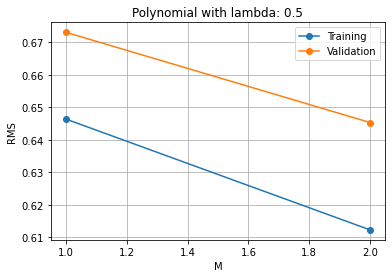

In [101]:
plt.title('Polynomial with lambda: '+str(Lambda))
plt.xlabel('M')
plt.ylabel('RMS')
plt.plot([1,2],[RMS_M1_train,RMS_M2_train],marker = "o",label='Training')
plt.plot([1,2],[RMS_M1_test,RMS_M2_test],marker = "o",label='Validation')
plt.legend(loc=0)
plt.grid('on')
plt.show()

In [81]:
# N-fold cross-validation with MAP
Lambda = 0.5
N = 10
ratio = 1 / N
n_test_NFold = int(n_target * ratio)
n_train_NFold = n_target - n_test_NFold
RMS_M1_train = np.zeros((1,N))
RMS_M1_test = np.zeros((1,N))
RMS_M2_train = np.zeros((1,N))
RMS_M2_test = np.zeros((1,N))

In [82]:
for r in range(N):
    dataset_x_test = dataset_x[range((n_test_NFold*r),(n_test_NFold*(r+1))),:]
    dataset_t_test = dataset_t[range((n_test_NFold*r),(n_test_NFold*(r+1))),:]
    dataset_x_train = np.delete(dataset_x, [range((n_test_NFold*r),(n_test_NFold*(r+1)))], axis=0)
    dataset_t_train = np.delete(dataset_t, [range((n_test_NFold*r),(n_test_NFold*(r+1)))], axis=0)
    
    # Create phi_matrix for M = 1 & M = 2
    matrix1_train = np.ones([1, n_train_NFold])
    matrix1_test = np.ones([1, n_test_NFold])
    matrix2_train = dataset_x_train.T
    matrix2_test = dataset_x_test.T
    matrix3_train = np.zeros((D**2,n_train_NFold))
    
    for i in range(0,n_train_NFold):
        m = 0
        for j in range(0,D):
            for k in range(0,D):
                matrix3_train[m,i] = dataset_x_train[i,j] * dataset_x_train[i,k]
                m = m + 1
    
    matrix3_test = np.zeros((D**2,n_test_NFold))
    
    for i in range(0,n_test_NFold):
        m = 0
        for j in range(0,D):
            for k in range(0,D):
                matrix3_test[m,i] = dataset_x_test[i,j] * dataset_x_test[i,k]
                m = m + 1
                
    phi_matrix_M1_train = np.vstack((matrix1_train, matrix2_train))
    phi_matrix_M1_test = np.vstack((matrix1_test, matrix2_test))
    phi_matrix_M2_train = np.vstack((matrix1_train, matrix2_train, matrix3_train))
    phi_matrix_M2_test = np.vstack((matrix1_test, matrix2_test, matrix3_test))
    
    # Weights for M = 1 & M = 2
    w_M1 = np.dot(np.dot(pinv(np.dot(phi_matrix_M1_train, phi_matrix_M1_train.T) + Lambda*np.eye(D+1)), phi_matrix_M1_train), dataset_t_train)
    w_M2 = np.dot(np.dot(pinv(np.dot(phi_matrix_M2_train, phi_matrix_M2_train.T) + Lambda*np.eye(1+D+D**2)), phi_matrix_M2_train), dataset_t_train)
    
    # RMSs
    RMS_M1_train[0,r] =((np.sum((np.dot(w_M1.T, phi_matrix_M1_train) - dataset_t_train.T)**2) + Lambda*np.dot(w_M1.T,w_M1)) / n_train_NFold)**0.5
    RMS_M1_test[0,r] = ((np.sum((np.dot(w_M1.T, phi_matrix_M1_test) - dataset_t_test.T)**2) + Lambda*np.dot(w_M1.T,w_M1)) / n_test_NFold)**0.5
    RMS_M2_train[0,r] = ((np.sum((np.dot(w_M2.T, phi_matrix_M2_train) - dataset_t_train.T)**2) + Lambda*np.dot(w_M2.T,w_M2)) / n_train_NFold)**0.5
    RMS_M2_test[0,r] = ((np.sum((np.dot(w_M2.T, phi_matrix_M2_test) - dataset_t_test.T)**2) + Lambda*np.dot(w_M2.T,w_M2)) / n_test_NFold)**0.5

In [83]:
a = [RMS_M1_train, RMS_M1_test, RMS_M2_train, RMS_M2_test]
name = ['RMS train (M=1)', 'RMS val (M=1)', 'RMS train (M=2)', 'RMS val (M=2)']
mean_list = list()
print("N-fold cross-validation with MAP")
print("lambda = ", Lambda, "\n")

for i in range(4):
    mu = np.mean(a[i])
    mean_list.append(mu)
    variance = np.var(a[i])
    print(name[i], ":")
    print("mean:     ", mu)
    print("variance: ", variance, "\n")

N-fold cross-validation with MAP
lambda =  0.5 

RMS train (M=1) :
mean:      0.6490363103427581
variance:  2.550916162478427e-05 

RMS val (M=1) :
mean:      0.6719694015201938
variance:  0.002204596275754025 

RMS train (M=2) :
mean:      0.6128239919045619
variance:  2.5624136104574677e-05 

RMS val (M=2) :
mean:      0.6550862013947581
variance:  0.0021547504419450144 



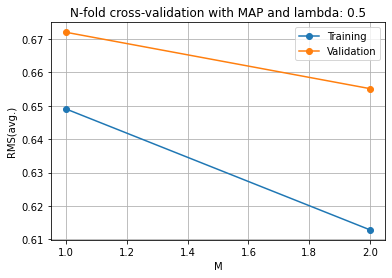

In [84]:
plt.title('N-fold cross-validation with MAP and lambda: '+str(Lambda))
plt.xlabel('M')
plt.ylabel('RMS(avg.)')
plt.plot([1,2],[mean_list[0],mean_list[2]],marker = "o",label='Training')
plt.plot([1,2],[mean_list[1],mean_list[3]],marker = "o",label='Validation')
plt.legend(loc=0)
plt.grid('on')
plt.show()